# Assignment 5 - Expectation Maximization

## Overview

Automatic image processing is a key component to many AI systems, including facial recognition and video compression, instance segmentation of images and point cloud data. One basic method for processing is segmentation, by which we divide an image into a fixed number of components in order to simplify its representation. For example, we can train a mixture of Gaussians to represent an image, and segment it according to the simplified representation as shown in the images below.

![alt text](images/k6_Starry.png)

Or we could perform a clustering of point cloud in order to separate different objects, backgrounds etc, as shown in the image below

![alt text](images/pcd_clustered.gif)

In this assignment, you will learn to perform image compression and point cloud segmentation. To this end, you will implement Gaussian mixture models and iteratively improve their performance. First you will perform segmentation on the "Starry" (`Starry.png`) and at the end run your algorithm on 3D point cloud data.

To begin, you will implement several methods of image segmentation, with increasing complexity:

1. Implement k-means clustering to segment a color image.

2. Familiarize yourself with the algorithm by running it on simple dataset.

3. Build a Gaussian mixture model to be trained with expectation-maximization.

4. Experiment with varying the details of the Gaussian mixture model’s implementation.

5. Implement and test a new metric called the Bayesian information criterion, which guarantees a more robust image segmentation.

<br>

- - -

## Part 0: Note on Vectorization

The concept of Vectorization was introduced in the last section of Assignment 4. For this assignment, please vectorize your code wherever possible using numpy arrays, instead of running for-loops over the images being processed.

For example of how this might be useful, consider the following array:
A = [12 34 1234 764 ...(has a million values)... 91, 78]

Now you need to calculate another array B, which has the same dimensions as A above. Say each value in B is calculated as follows:
(each value in B) = square_root_of(some constants pi log(k) * (each value in A))/7

You might wish to use a for-loop to compute this. However, it will take really long to run on an array of this magnitude.
Alternatively, you may choose to use numpy and perform this calculation in a single line. You can pass A as a numpy array and the entire calculation will be done in a line, resulting in B being populated with the corresponding values that come out of this formula.

Check out **Basic Operation** section of the Numpy Tutorial if you are not familiar with numpy vector/matrix operations: https://docs.scipy.org/doc/numpy/user/quickstart.html#basic-operations

#### Please note that numpy.vectorize DOES NOT perform vectorization, it only does a loop. 


## Part 1: K-means Clustering (19 pts)

One easy method for image segmentation is to simply cluster all similar data points together and then replace their values with the mean value. Thus, we'll warm up using k-means clustering. This will also provide a baseline to compare with your segmentation. Please note that clustering will come in handy later.

Fill out `get_initial_means()`, `k_means_step()` functions below.

In `get_initial_means()`, you should choose  k random points from the data (without replacement) to use as initial cluster means.

Your code will be unit tested automatically when you run the cell (`Cell > Run Cells OR Shift + Enter`).

#### Try to vectorize the code for it to run faster. Without vectorization it takes 25-30 minutes for the code to run.


In [1]:
%load_ext autoreload
%autoreload 2
# Run this cell and check if you have all necessary modules
from ipywidgets import *
import mixture_tests as tests
import matplotlib.pyplot as plt
import matplotlib.patches as pat
from scipy.stats import norm
import os
import numpy as np
from helper_functions import *
# Please don't modify this cell

In [2]:
#export
import numpy as np
from helper_functions import *

In [28]:
#export
def get_initial_means(array, k):
    """
    Picks k ͏random ͏points⠀from⠀the ͏2D array 

    (without replacement) ͏to ͏use⠀as ͏initial ͏

    cluster means

    params:
    array =⠀numpy.ndarray[numpy.ndarray[float]] ͏- ͏m ͏x ͏n | datapoints x features


    k = int

    returns:
    initial_means = numpy.ndarray[numpy.ndarray[float]]
    """
    # TODO: finish this function
    m,n = array.shape
    means_arr = np.random.choice(m, k, replace=False)
    initial_means = array[means_arr, :]
    
    return initial_means
    
########## DON'T⠀WRITE ͏ANY ͏CODE ͏OUTSIDE⠀THE FUNCTION! ################

##### CODE ͏BELOW⠀IS ͏USED⠀FOR ͏RUNNING LOCAL TEST DON'T MODIFY IT ######

tests.K_means_test().test_initial_means(get_initial_means)
################ END ͏OF⠀LOCAL ͏TEST⠀CODE ͏SECTION ######################


UnitTest passed successfully!


In [40]:
#export
def k_means_step(X, k, means):
    """
    A single ͏update/step ͏of⠀the⠀K-means⠀algorithm

    Based on⠀a⠀input⠀X ͏and ͏current mean estimate,

    predict clusters⠀for ͏each⠀of⠀the ͏pixels and 

    calculate new means. 
    params:
    X =⠀numpy.ndarray[numpy.ndarray[float]]⠀-⠀m ͏x⠀n | pixels x features (already flattened)

    k = int
    means =⠀numpy.ndarray[numpy.ndarray[float]]⠀-⠀k⠀x⠀n


    returns:
    (new_means, clusters)
    new_means = ͏numpy.ndarray[numpy.ndarray[float]] ͏-⠀k⠀x ͏n

    clusters = ͏numpy.ndarray[int] ͏-⠀m ͏sized ͏vector

    """
    # TODO: finish this function
    m,n = X.shape
    distance_matrix = np.zeros((m, k))
    for i in range(k):        
        distance = np.sqrt(np.sum((X - means[i, :])**2, axis=1))  #shape (m,)
        distance_matrix[:, i] = distance
        
    clusters = np.argmin(distance_matrix, axis=1).astype(int)  #shape (m,)
    
    new_means = np.zeros((k, n))
    for i in range(k):
        index = np.where(clusters == i)[0]    #shape (m,)
        new_means[i, :] = np.sum(X[index,:], axis=0)/index.shape[0]
    
    return (new_means, clusters)

########## DON'T⠀WRITE ͏ANY ͏CODE ͏OUTSIDE ͏THE FUNCTION! ################

##### CODE⠀BELOW ͏IS ͏USED ͏FOR⠀RUNNING LOCAL TEST DON'T MODIFY IT ######

tests.K_means_test().test_k_means_step(k_means_step)
################ END ͏OF⠀LOCAL ͏TEST⠀CODE ͏SECTION ######################


UnitTest passed successfully!


#### K-means - Visualizing the results

Now that you are done with the K-means step implementation lets try to visualize what's happening if you repeat these steps multiple times.

**You don't need to be implementing anything in the next cells until Image Segmentation Section**, but you are highly encouraged to play with parameters and datasets, to get a sense of what is happening at every algorithm iteration step.

Feel free to explore and improve the function below, it will be used for visualizing K-means progress
but it's not required and WON'T effect your grade.

In [25]:
# This cell contains a code for loading a dataset from the `data` folder
# Each of these datasets contains synthtic (generated) data
# You can simply run this cell for now and come back to it later if you want to make changes
# Make sure you implemented everything in cells above and passed the unittests
def K_means_2D_dataset(dataset_index, K):
    # Load the dataset from data folder
    X = np.loadtxt("data/%d_dataset_X.csv" % dataset_index, delimiter=",")
    print("The dataset is of a size:", X.shape)

    # Load the labels
    # Clustering is unsupervised method, where no labels are provided
    # However, since we generated the data outselves we know the clusters,
    # and load them for illustration purposes.
    y = np.int16(np.loadtxt("data/%d_dataset_y.csv" % dataset_index, delimiter=","))

    # Feel free to edit the termination condition for the K-means algorithm
    # Currently is just runs for n_iterations, before terminating
    n_iterations = 10
    m,n = X.shape
    means = get_initial_means(X,K)
    clusters = np.zeros([n])
    # keeping track of how clusters and means changed, for visualization purposes
    means_history = [means]
    clusters_history = [clusters] 
    for iteration_i in range(n_iterations):
        means, clusters = k_means_step(X, K, means)
        clusters_history.append(clusters)

    return X, y, means_history, clusters_history

# Things to try:
# - Try different initialization to see check initialization robustness
# - Improve the termination condition (you will be able to reuse later as well!)
# - Try creating you own dataset in the `data/` folder 

In [26]:
# RUN - TRY DIFFERENT PARAMETERS - REPEAT
dataset_index = 2 # for different dataset change it to number from [0,4]
K = 5 # Number of clusters - play with this number

X, y, means_history, clusters_history = K_means_2D_dataset(dataset_index, K)

# This is an interactive cell to see the progress of training your K-means algorithm.
# Feel free to improve the visualization code and share it with your classmates on Piazza
def get_cluster(i):
    clusters = clusters_history[i] # Get the clusters from K-means' i-th iteration
    plt.figure(None, figsize=(15,6)) # Set the plot size
    plt.suptitle('Drag the slider to see the algorthm training progress')
    ax1=plt.subplot(1, 2, 1)
    ax1.set_title('K-means clusters - step %d' % i)
    for k in range(K):
        plt.plot(X[clusters==k,0], X[clusters==k,1], '.') # 
        # Try to plot the centers of the clusters 
        # You can access them by calling means_history[i]
        # How could you plot the area that belong to that cluster?

    # Just to get a flavour of how the data looks like
    ax2=plt.subplot(1, 2, 2)
    ax2.set_title('Ground truth clusters')
    for i in np.unique(y):
        ax2.plot(X[y==i,0],X[y==i,1],'.')

    plt.show()

interactive(get_cluster, i=(1,len(clusters_history)-1,1))

The dataset is of a size: (1000, 2)


interactive(children=(IntSlider(value=5, description='i', max=10, min=1), Output()), _dom_classes=('widget-int…

### Image segmentation
2D data clustering is all cool and all but now it's time to use K-means for the image compression! 

Fill in the `k_means_segment()` function below, you will find your `k_means_step()` and `get_initial_means()` very handy here. 

You will separate the provided RGB values into k clusters using the k-means algorithm, then return an updated version of the image with the original values replaced with the corresponding cluster center values.

Your convergence test should be whether the assigned clusters stop changing. Note that this convergence test is rather slow. When no initial cluster means (`initial_means`) are provided, you need to initialize them yourself, based on the given k.

For this part of the assignment, since clustering is best used on multidimensional data, we will be using the color image `Starry.png`.

Please pay close attention to the dimensions of the data. In the `k_means_step()` you were working with m x n data, here the input is an image (`image_values`) which has a shape of **rows x columns x color_channels**.

The function should return an updated version of the image with the original values replaced with the corresponding cluster values.

In [41]:
#export
def k_means_segment(image_values, k=3, initial_means=None):
    """
    Separate the provided RGB values into
    k separate ͏clusters⠀using ͏the⠀k-means ͏algorithm,

    then return ͏an ͏updated⠀version⠀of⠀the image

    with the original values replaced with
    the corresponding cluster values.

    params:
    image_values =⠀numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]]⠀-⠀r ͏x ͏c x ch

    k = int
    initial_means = numpy.ndarray[numpy.ndarray[float]] or None

    returns:
    updated_image_values =⠀numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] ͏-⠀r⠀x ͏c x ch

    """
    # TODO: finish this function
    img = image_values.copy()
    m, n, d = img.shape
    img_array = np.reshape(img,(-1,d))
    
    if initial_means is None:
        initial_means = get_initial_means(img_array, k)
    
    e = 1
    means, clusters = k_means_step(img_array, k, initial_means)
    
    while(e != 0):
        new_means, new_clusters = k_means_step(img_array, k, means)
        e = np.sum(abs(clusters - new_clusters))
        clusters = new_clusters
        means = new_means
    
    for i in range(m*n):
        img_array[i, :] = new_means[clusters[i], :]
        
    updated_image_values = img_array.reshape((m, n, d))
    
    return updated_image_values
        

########## DON'T⠀WRITE⠀ANY⠀CODE ͏OUTSIDE⠀THE FUNCTION! ################

##### CODE⠀BELOW⠀IS⠀USED⠀FOR⠀RUNNING LOCAL TEST DON'T MODIFY IT ######

tests.K_means_test().test_k_means(k_means_segment)
################ END ͏OF ͏LOCAL⠀TEST⠀CODE ͏SECTION ######################


UnitTest passed successfully!


### Visulizing K-means segmentation results

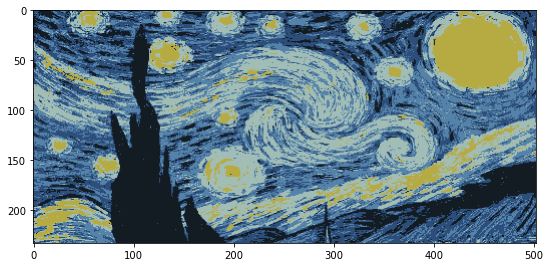

In [42]:
k=5 # number of clusters - feel free to play with it

image_values = image_to_matrix('images/Starry.png')
# Play with the K value below to see the effect number of clusters have
new_image = k_means_segment(image_values, k=k)

plt.figure(None,figsize=(9,12))
plt.imshow(new_image)
plt.show()


You can reuse the K-means visualization code from previous section to show the training progress on the image for different iterations and even numbers of clusters.

- - -

## Part 2: Implementing a Multivariate Gaussian Mixture Model (48 pts)

Next, we will step beyond clustering and implement a complete Gaussian mixture model.

But, before you dive into the code, you are highly encouraged to go over `read/gaussians.pdf` file before you start, to familiarize yourself with multivariate case of the Gaussian distribution.

In addition to that, there is a great ~17 minute video where Alexander Ihler goes over nuts and bolds of the multivariate EM algorithm details on Youtube:
https://www.youtube.com/watch?v=qMTuMa86NzU

Another resource you can refer to is the `read/em.pdf` document attached, which is a chapter from Pattern Recognition and Machine Learning book by Christopher M. Bishop.

- - - 

Now, it's time to complete the implementation of the functions below what will later assemble into a Multivariate Gaussian Expectation Maximization algorithm:

1. Calculate the probability of a given data point (e.g. rgb value of a pixel) of belonging to a specific Gaussian component. (7 points)

2. Use expectation-maximization (EM) to train the model to represent the image as a mixture of Gaussians. (20 points)

To initialize EM, set each component's mean to the means value of randomly chosen pixels (same as for K-means) and calculate covariances based on the selected means, and set the mixing coefficients to a uniform distribution. 

We've set the convergence condition for you in `default_convergence()` (see `helper_functions.py` file): if the new likelihood is within 10% of the previous likelihood for 10 consecutive iterations, the model has converged.

**Note:** there are packages that can run EM automagically, but you have to implement your own version of EM without using these extra packages. **It also means that you are not allowed to look into any implementations of the algorithms, e.g scikit-learn and many others. NumPy is your only tool here.** 

3. Calculate the log likelihood of the trained model. (7 points)
4. Segment the image according to the trained model. (7 points)
5. Determine the best segmentation by iterating over model training and scoring, since EM isn't guaranteed to converge to the global maximum. (7 points)

It'd be helpful to implement the above functions in the following order - 
1. initialize_parameters
2. prob
3. E_step
4. M_step
5. likelihood 
6. train_model
7. cluster
8. segment
9. best_segment

### Warning: You may lose all marks for this part if your code runs for too long.

**You will need to vectorize your code in this part. Specifically, the method E_step() and M_step() which make up the train_model(), perform operations using numpy arrays. These are time-sensitive functions and will be called over and over as you proceed with this assignment.**

For the synthetic data test which we provide to check if your training is working, the set is too small and it won't make a difference. But with the actual image that we use ahead, for-loops won't do good. Vectorized code would take under 30 seconds to converge which would typically involve about 15-20 iterations with the convergence function we have here. Inefficient code that uses loops or iterates over each pixel value sequentially, will take hours to run. You don't want to do that.

- - -

Same as in K-means you will be working with the data of size (m x n). 

In [37]:
#export
def initialize_parameters(X, k):
    """
    Return initial ͏values ͏for⠀training ͏of ͏the GMM

    Set component mean to a random
    pixel's value (without replacement),
    based on⠀the ͏mean ͏calculate ͏covariance ͏matrices,

    and set⠀each ͏component ͏mixing ͏coefficient⠀(PIs)

    to a uniform values
    (e.g. 4 components -> [0.25,0.25,0.25,0.25]).
    
    params:
    X = ͏numpy.ndarray[numpy.ndarray[float]]⠀- ͏m⠀x ͏n

    k = int
    
    returns:
    (MU, SIGMA, PI)
    MU = ͏numpy.ndarray[numpy.ndarray[float]]⠀- ͏k⠀x ͏n

    SIGMA = ͏numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] ͏-⠀k⠀x⠀n x n

    PI =⠀numpy.ndarray[float]⠀-⠀k ͏x ͏1 

    """
    # TODO: finish this function
    array = X.copy()
    m,n = array.shape
    means_arr = np.random.choice(m, k, replace=False)
    MU = array[means_arr, :]
    
    SIGMA = np.zeros((k, n, n))
    for i in range(k):
        c_array = array - MU[i]
        SIGMA[i, :, :] = np.dot(c_array.T, c_array) / m
    
    PI = 1/k * np.ones(k)
    
    return (MU, SIGMA, PI)
    

########## DON'T⠀WRITE ͏ANY⠀CODE⠀OUTSIDE ͏THE FUNCTION! ################

##### CODE⠀BELOW⠀IS⠀USED ͏FOR⠀RUNNING LOCAL TEST DON'T MODIFY IT ######

tests.GMMTests().test_gmm_initialization(initialize_parameters)
################ END⠀OF⠀LOCAL⠀TEST⠀CODE⠀SECTION ######################


UnitTest passed successfully!


The following cell (compute_sigma) will not be graded, but we highly recommend using this function and paired test to make sure your covariance matrix implementation is correct. Computing the covariance matrix incorrectly can result in problems that become extremely hard to debug later in the assignment so please take advantage of this section.

In [21]:
def compute_sigma(X, MU):
    """
    Calculate covariance matrix, based in given X and MU values
    
    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    
    returns:
    SIGMA = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - k x n x n
    """
    # TODO: finish this function
    array = X.copy()
    m,n = array.shape
    k = MU.shape[0]
    SIGMA = np.zeros((k, n, n))
    
    for i in range(k):
        c_array = array - MU[i]
        SIGMA[i, :, :] = np.dot(c_array.T, c_array) / m

    return SIGMA

########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_gmm_covariance(compute_sigma)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


# NOTE:

### Be careful when coding up prob() below. It is fine for prob() to take the vectorized approach, but you may have to adjust your implementation to handle both cases. Specifically the case where x is a single datapoint and where x is an entire array of datapoints.

In [22]:
#export
def prob(x, mu, sigma):
    """Calculate the probability of a single
    data point x under component with
    the given mean and covariance.
    # NOTE: ͏there ͏is⠀nothing⠀to ͏vectorize here yet,

    # it's ͏a ͏simple⠀check ͏to ͏make sure you got the

    # multivariate normal distribution formula right
    # which⠀is ͏given ͏by ͏N(x;MU,SIGMA) ͏above


    params:
    x = numpy.ndarray[float] or numpy.ndarray[numpy.ndarray[float]]
    mu = numpy.ndarray[float]
    sigma = numpy.ndarray[numpy.ndarray[float]]

    returns:
    probability = float or numpy.ndarray[float]
    """
    # TODO: finish this function
    array = np.atleast_2d(x)
    m,n = array.shape
    det_sigma = np.linalg.det(sigma)
    inv_sigma = np.linalg.inv(sigma)
    
    b = 1/np.sqrt((2*np.pi)**n * det_sigma)
    t = np.zeros(m)
    array = array - mu
    
    for i in range(m):
        t[i] = np.exp(-0.5 * array[i, :].dot(inv_sigma).dot(array[i, :]))

    p = b * t
    
    if m == 1:
        return p[0]
    
    return p               # shape (m,)

########## DON'T⠀WRITE ͏ANY ͏CODE ͏OUTSIDE⠀THE FUNCTION! ################

##### CODE ͏BELOW⠀IS ͏USED⠀FOR ͏RUNNING LOCAL TEST DON'T MODIFY IT ######

tests.GMMTests().test_gmm_prob(prob)
################ END ͏OF⠀LOCAL ͏TEST⠀CODE ͏SECTION ######################


UnitTest passed successfully!


In [52]:
#export
def E_step(X,MU,SIGMA,PI,k):
    """
    E-step - Expectation 
    Calculate responsibility for each
    of the ͏data ͏points,⠀for⠀the⠀given 

    MU, SIGMA and PI.
    
    params:
    X =⠀numpy.ndarray[numpy.ndarray[float]]⠀-⠀m ͏x ͏n

    MU =⠀numpy.ndarray[numpy.ndarray[float]] ͏-⠀k⠀x ͏n

    SIGMA =⠀numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]]⠀-⠀k ͏x⠀n x n

    PI =⠀numpy.ndarray[float]⠀-⠀k⠀x⠀1

    k = int
    
    returns:
    responsibility = ͏numpy.ndarray[numpy.ndarray[float]] ͏-⠀k⠀x ͏m

    """
    # TODO: finish this function
    
    array = X.copy()
    array = np.atleast_2d(array)
    m,n = array.shape
    responsibility = np.zeros((k, m))
    
    for i in range(k):
        responsibility[i, :] = prob(array, MU[i], SIGMA[i, :, :])
        
    responsibility = np.einsum('i,ij->ij', PI, responsibility)
    rsum = np.einsum('ij->j', responsibility)
    
    responsibility = responsibility / rsum
        
    return responsibility
########## DON'T ͏WRITE ͏ANY⠀CODE ͏OUTSIDE ͏THE FUNCTION! ################

##### CODE⠀BELOW ͏IS ͏USED ͏FOR ͏RUNNING LOCAL TEST DON'T MODIFY IT ######

tests.GMMTests().test_gmm_e_step(E_step)
################ END⠀OF ͏LOCAL ͏TEST ͏CODE⠀SECTION ######################


UnitTest passed successfully!


In [53]:
#export
def M_step(X, r, k):
    """
    M-step - Maximization
    Calculate new ͏MU,⠀SIGMA ͏and⠀PI ͏matrices

    based on the given responsibilities.
    
    params:
    X = ͏numpy.ndarray[numpy.ndarray[float]]⠀- ͏m⠀x ͏n

    r = ͏numpy.ndarray[numpy.ndarray[float]] ͏-⠀k⠀x⠀m

    k = int
    
    returns:
    (new_MU, new_SIGMA, new_PI)
    new_MU =⠀numpy.ndarray[numpy.ndarray[float]]⠀-⠀k ͏x ͏n

    new_SIGMA =⠀numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] ͏-⠀k⠀x ͏n x n

    new_PI =⠀numpy.ndarray[float]⠀-⠀k ͏x⠀1

    """
    # TODO: finish this function
    array = X.copy()
    m,n = array.shape

    new_MU = np.zeros((k, n))
    new_SIGMA = np.zeros((k, n, n))  
    new_PI = np.zeros(k)
    
    for i in range(k):
        mc = np.sum(r[i, :])
        
        new_MU[i, :] = 1/mc * np.einsum('i,ij->j', r[i, :], array)
        
        c_array = array - new_MU[i]
        c_array_t = c_array.T
        c_array = np.einsum('i,ij->ij', r[i, :], c_array)
        new_SIGMA[i, :, :] = np.dot(c_array_t, c_array)/mc
        
        new_PI[i] = mc/m

    return (new_MU, new_SIGMA, new_PI)

########## DON'T⠀WRITE⠀ANY⠀CODE⠀OUTSIDE⠀THE FUNCTION! ################

##### CODE ͏BELOW ͏IS⠀USED⠀FOR ͏RUNNING LOCAL TEST DON'T MODIFY IT ######

tests.GMMTests().test_gmm_m_step(M_step)
################ END ͏OF ͏LOCAL⠀TEST ͏CODE ͏SECTION ######################


UnitTest passed successfully!


In [56]:
#export
def likelihood(X, PI, MU, SIGMA, k):
    """Calculate a⠀log ͏likelihood ͏of ͏the ͏

    trained model based on the following
    formula for posterior probability:
    
    log(Pr(X |⠀mixing, ͏mean, ͏stdev)) ͏=⠀sum((n=1 to N), log(sum((k=1 to K),

                                      mixing_k * N(x_n | mean_k,stdev_k))))

    Make sure ͏you⠀are ͏using⠀natural ͏log, instead of log base 2 or base 10.

    
    params:
    X = ͏numpy.ndarray[numpy.ndarray[float]]⠀- ͏m⠀x ͏n

    MU = ͏numpy.ndarray[numpy.ndarray[float]] ͏-⠀k⠀x⠀n

    SIGMA =⠀numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]]⠀-⠀k ͏x ͏n x n

    PI =⠀numpy.ndarray[float] ͏-⠀k⠀x ͏1

    k = int

    returns:
    log_likelihood = float
    """
    # TODO: finish this function
    array = X.copy()
    m, n = array.shape
    log_likelihood = 0

    p = np.zeros((k, m))
    for c in range(k):
        p[c, :] = prob(array, MU[c], SIGMA[c, :, :]) * PI[c]
        
    sum_c = np.sum(p, axis=0)
    log_likelihood = np.sum(np.log(sum_c))
            
    return log_likelihood

########## DON'T⠀WRITE⠀ANY⠀CODE ͏OUTSIDE⠀THE FUNCTION! ################

##### CODE⠀BELOW⠀IS⠀USED⠀FOR⠀RUNNING LOCAL TEST DON'T MODIFY IT ######

tests.GMMTests().test_gmm_likelihood(likelihood)
################ END ͏OF ͏LOCAL⠀TEST⠀CODE ͏SECTION ######################


UnitTest passed successfully!


In [20]:
#export
def train_model(X, k, convergence_function, initial_values = None):
    """
    Train the ͏mixture ͏model⠀using ͏the ͏

    expectation-maximization algorithm. 
    E.g., iterate⠀E ͏and ͏M ͏steps ͏from 

    above until convergence.
    If the⠀initial_values ͏are ͏None, ͏initialize⠀them.

    Else it's ͏a⠀tuple ͏of⠀the ͏format (MU, SIGMA, PI).

    Convergence is reached when convergence_function
    returns terminate as True,
    see default convergence_function example 
    in `helper_functions.py`

    params:
    X = ͏numpy.ndarray[numpy.ndarray[float]]⠀- ͏m⠀x ͏n

    k = int
    convergence_function = func
    initial_values = ͏None ͏or⠀(MU,⠀SIGMA,⠀PI)


    returns:
    (new_MU, new_SIGMA, new_PI, responsibility)
    new_MU =⠀numpy.ndarray[numpy.ndarray[float]]⠀-⠀k ͏x ͏n

    new_SIGMA =⠀numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] ͏-⠀k⠀x ͏n x n

    new_PI =⠀numpy.ndarray[float]⠀-⠀k ͏x⠀1

    responsibility =⠀numpy.ndarray[numpy.ndarray[float]]⠀-⠀k⠀x⠀m

    """
    # TODO: finish this function
    array = X.copy()
    m, n = array.shape
    
    if initial_values is None:
        MU, SIGMA, PI = initialize_parameters(array, k)
    else:
        MU, SIGMA, PI = initial_values
        
    end = False
    prev_likelihood = 0
    new_likelihood = 0
    conv_ctr = 0
    
    while(not end):
        responsibility = E_step(array, MU, SIGMA, PI, k)
        new_MU, new_SIGMA, new_PI = M_step(array, responsibility, k)
        MU = new_MU
        SIGMA = new_SIGMA
        PI = new_PI
        
        new_likelihood = likelihood(array, PI, MU, SIGMA, k)        
        conv_ctr, end = convergence_function(prev_likelihood, new_likelihood, conv_ctr, conv_ctr_cap=10)    
        prev_likelihood = new_likelihood
            
    return (MU, SIGMA, PI, responsibility)

########## DON'T ͏WRITE ͏ANY⠀CODE⠀OUTSIDE ͏THE FUNCTION! ################

##### CODE ͏BELOW ͏IS⠀USED ͏FOR ͏RUNNING LOCAL TEST DON'T MODIFY IT ######

tests.GMMTests().test_gmm_train(train_model, likelihood)
################ END⠀OF ͏LOCAL ͏TEST ͏CODE ͏SECTION ######################


UnitTest passed successfully!
35.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [26]:
#export
def cluster(r):
    """
    Based on a given responsibilities matrix
    return an array of cluster indices.
    Assign each⠀datapoint ͏to ͏a ͏cluster⠀based,

    on component with a max-likelihood 
    (maximum responsibility value).
    
    params:
    r = ͏numpy.ndarray[numpy.ndarray[float]]⠀- ͏k⠀x ͏m - responsibility matrix

    
    return:
    clusters = ͏numpy.ndarray[int]⠀- ͏m⠀x ͏1 

    """
    # TODO: finish this
    clusters = np.argmax(r, axis=0)
    
    return clusters

########## DON'T ͏WRITE ͏ANY⠀CODE⠀OUTSIDE⠀THE FUNCTION! ################

##### CODE⠀BELOW⠀IS⠀USED ͏FOR ͏RUNNING LOCAL TEST DON'T MODIFY IT ######

tests.GMMTests().test_gmm_cluster(cluster)
################ END⠀OF ͏LOCAL⠀TEST⠀CODE ͏SECTION ######################


UnitTest passed successfully!


In [35]:
#export
def segment(X, MU, k, r):
    """
    Segment the⠀X⠀matrix⠀into ͏k⠀components. 

    Returns a⠀matrix⠀where⠀each⠀data⠀point is 

    replaced with its max-likelihood component mean.
    E.g., return ͏the ͏original⠀matrix⠀where ͏each pixel's

    intensity replaced with its max-likelihood 
    component mean. ͏(the ͏shape⠀is ͏still ͏mxn, not 

    original image size)

    params:
    X =⠀numpy.ndarray[numpy.ndarray[float]] ͏- ͏m ͏x ͏n

    MU =⠀numpy.ndarray[numpy.ndarray[float]] ͏- ͏k ͏x⠀n

    k = int
    r = ͏numpy.ndarray[numpy.ndarray[float]]⠀- ͏k⠀x ͏m - responsibility matrix


    returns:
    new_X = ͏numpy.ndarray[numpy.ndarray[float]]⠀- ͏m⠀x ͏n

    """
    # TODO: finish this function
    array = X.copy()
    m,n = array.shape
    img_array = np.zeros((m,n))
    clusters = cluster(r)
    
    for i in range(m):
        img_array[i, :] = MU[clusters[i], :]
        
    return img_array

########## DON'T ͏WRITE ͏ANY⠀CODE⠀OUTSIDE⠀THE FUNCTION! ################

##### CODE⠀BELOW⠀IS⠀USED ͏FOR ͏RUNNING LOCAL TEST DON'T MODIFY IT ######

tests.GMMTests().test_gmm_segment(train_model, segment)
################ END⠀OF ͏LOCAL⠀TEST⠀CODE ͏SECTION ######################


UnitTest passed successfully!


In [39]:
#export
def best_segment(X,k,iters):
    """Determine the best segmentation
    of the image by repeatedly
    training the model and
    calculating its likelihood.
    Return the segment with the
    highest likelihood.

    params:
    X =⠀numpy.ndarray[numpy.ndarray[float]]⠀-⠀m ͏x⠀n

    k = int
    iters = int

    returns:
    (likelihood, segment)
    likelihood = float
    segment = numpy.ndarray[numpy.ndarray[float]]
    """
    # TODO: finish this function
    array = X.copy()
    best_values = None
    p = -np.inf
    
    for i in range(iters):
        initial_values = initialize_parameters(array, k)
        MU, SIGMA, PI, responsibility = train_model(array, k, default_convergence, initial_values)

        p_new = likelihood(array, PI, MU, SIGMA, k)
        
        if p_new > p:
            p = p_new
            bset_values = (MU, SIGMA, PI, responsibility)
            
    new_segment = segment(array, bset_values[0], k, bset_values[3])
#     print(p)
    
    return (p, new_segment)

########## DON'T⠀WRITE⠀ANY⠀CODE⠀OUTSIDE⠀THE FUNCTION! ################

##### CODE ͏BELOW ͏IS⠀USED⠀FOR ͏RUNNING LOCAL TEST DON'T MODIFY IT ######

tests.GMMTests().test_gmm_best_segment(best_segment)
################ END ͏OF ͏LOCAL⠀TEST ͏CODE ͏SECTION ######################


UnitTest passed successfully!


#### GMM - Visualizing the results

Now that you are done with the EM implementation lets try to visualize what's happening if you repeat these steps multiple times.

**You don't need to be implementing anything in the next 2 cells, but you are highly encouraged to play with parameters and datasets, to get a visual sense of what is happening at every step.**


Feel free to explore and improve the function below, it will be used for visualizing GMM progress
but it's not required and WON'T effect your grade.

In [98]:
def GMM_2D_dataset(dataset_index, K):
    # Load the dataset from data folder
    X = np.loadtxt("data/%d_dataset_X.csv" % dataset_index, delimiter=",")
    print("There are %d datapoints in the current dataset, each of a size %d" % X.shape)
    print("""\nNote that that the Gaussian Ellipses and Normal Curves may not share the
same color as the points they represent (within the same chart).
In fact, the Gaussian Ellipses and Normal Curves represent the clusters
in the top left chart (and thus share colors with those points).""")
    # Load the labels
    # Clustering is unsupervised method, where no labels are provided
    # However, since we generated the data outselves we know the labels,
    # and load them for illustration purposes.
    y = np.int16(np.loadtxt("data/%d_dataset_y.csv" % dataset_index, delimiter=","))
    # Feel free to edit the termination condition for the EM algorithm
    # Currently is just runs for n_iterations, before terminating
    
    MU, SIGMA, PI = initialize_parameters(X, K)
    
    clusters_history = []
    statistics_history = []
    for _ in range(200):
        r = E_step(X,MU,SIGMA,PI,K)
        new_MU, new_SIGMA, new_PI = M_step(X, r, K)
        PI, MU, SIGMA = new_PI, new_MU, new_SIGMA
        clusters = cluster(r)
        clusters_history.append(clusters)
        statistics_history.append((PI, MU, SIGMA))

    return X, y, clusters_history, statistics_history

In [99]:
# TRY DIFFERENT PARAMETERS
dataset_index = 3 # for different dataset change it to number from [0,5]
K = 3 # Number of clusters - play with this number

X, y, clusters_history, statistics_history = GMM_2D_dataset(dataset_index, K)

def setup_subplot(plt, i, title, plot_number):
    ax = plt.subplot(2, 2, plot_number)
    ax.set_title(title)
    ax.patch.set_facecolor('gray')
    ax.patch.set_alpha(0.1)
    return ax

def plot_gaussian_ellipse(k, mean, covar, ax2, colors):
    v,w = np.linalg.eig(covar)
        
    angle = np.arctan(w[1,0] / w[0,0])
    angle = 180 * angle / np.pi
    
    color = colors[k % len(colors)]
    for i in range(3,8):
        plot_v = i * np.sqrt(v)
        ellipse = pat.Ellipse(mean, plot_v[0], plot_v[1], angle, fill = True, alpha = 0.10, lw = 1.0, ls = 'dashdot', ec = 'black', fc = color, zorder = 0)
        ax2.add_artist(ellipse)

def plot_gaussian(X, mean, var, X_min, X_max, ax):
    samples = np.linspace(X_min, X_max, 100)
    ax.plot(samples, norm.pdf(samples, mean, var))
    

# This is an interactive cell to see the progress of training your GMM algorithm.
# Feel free to improve the visualization code and share it with your classmates on Piazza.
def get_cluster(i):
    clusters = clusters_history[i] # Get the clusters from K-means' i-th iteration
    cluster_means = statistics_history[i][1]
    cluster_covar = statistics_history[i][2]
    
    plt.figure(None, figsize=(15,12)) # Set the plot size
    plt.suptitle('Drag the slider to see the algorithm training progress')
    
    ax1 = setup_subplot(plt, i, 'GMM clusters - step %d' % i, 1)
    ax2 = setup_subplot(plt, i, 'Ground truth clusters', 2)
    ax3 = setup_subplot(plt, i, 'GMM Gausians X1 - step %d' % i, 3)
    ax4 = setup_subplot(plt, i, 'GMM Gausians X2 - step %d' % i, 4)
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for k in range(K):
        ax1.plot(X[clusters==k, 0], X[clusters==k, 1], '.')
        
        mean = cluster_means[k]
        covar = cluster_covar[k]
        
        plot_gaussian_ellipse(k, mean, covar, ax2, colors)
        plot_gaussian(X[clusters==k, 0], mean[0], covar[0,0], np.min(X[:, 0]), np.max(X[:, 0]), ax3)
        plot_gaussian(X[clusters==k, 1], mean[1], covar[1,1], np.min(X[:, 1]), np.max(X[:, 1]), ax4)
    
    ax3.set_prop_cycle(None)
    ax4.set_prop_cycle(None)
    # Just to get a flavour of how the data looks like
    for i in np.unique(y):
        ax2.plot(X[y==i,0], X[y==i,1],'.', zorder=10)
        ax3.plot(X[y==i,0], np.zeros(X[y==i,0].shape[0]), '.', zorder = 10)
        ax4.plot(X[y==i,1], np.zeros(X[y==i,1].shape[0]), '.', zorder = 10)
    
    plt.show()

interactive(get_cluster, {'manual': True}, i=(0,len(clusters_history)-1,1))


There are 1000 datapoints in the current dataset, each of a size 2

Note that that the Gaussian Ellipses and Normal Curves may not share the
same color as the points they represent (within the same chart).
In fact, the Gaussian Ellipses and Normal Curves represent the clusters
in the top left chart (and thus share colors with those points).


interactive(children=(IntSlider(value=99, description='i', max=199), Button(description='Run Interact', style=…

### Let's visualize the image compression results of GMM.

221630.4830026352


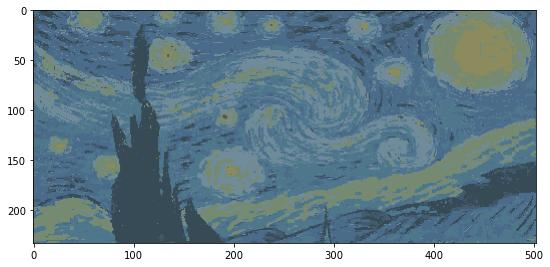

In [100]:
image_file = 'images/Starry.png' # Image path
original_image_matrix = image_to_matrix(image_file) # Save original image
image_matrix = original_image_matrix.reshape(-1,3) # collapse the dimension
K = 10 # K

_, best_seg = best_segment(image_matrix, K, iters = 10)
new_image = best_seg.reshape(*original_image_matrix.shape) # reshape collapsed matrix to original size
# Show the image
plt.figure(None,figsize=(9,12))
plt.imshow(new_image)
plt.show()

---

## Part 3: Model Experimentation (20 pts)

We'll now experiment with a few methods for improving GMM performance.

## Part 3a: Improved Initialization 

#### 12.5 points

To run EM in our baseline Gaussian mixture model, we use random initialization to determine the initial values for our component means. We can do better than this!

Fill in `improved_initialization()` by training a GMM to find initial means. This type of initialization differs from simply increasing training time because we "reset" the covariance and mixing coefficient parameters. That is, for training, we recompute covariance parameters based on the means we learned during initialization and again set the mixing coefficients to a uniform distribution. A GMM tends to converge to elongated covariances, so by resetting these parameters we have a higher chance of avoiding local maxima.

Please don't use any external packages for anything other than basic calculations. Note that your improvement might significantly slow down runtime, although we don't expect you to spend more than 10 minutes on initialization.

In [77]:
#export
def improved_initialization(X,k):
    """
    Initialize the training
    process by setting each
    component mean using some algorithm that
    you think⠀might ͏give ͏better ͏means ͏to start with,

    based on⠀the ͏mean ͏calculate ͏covariance⠀matrices,

    and set ͏each⠀component ͏mixing⠀coefficient ͏(PIs)

    to a uniform values
    (e.g. 4 components -> [0.25,0.25,0.25,0.25]).
    
    params:
    X = ͏numpy.ndarray[numpy.ndarray[float]]⠀- ͏m⠀x ͏n

    k = int
    
    returns:
    (MU, SIGMA, PI)
    MU = ͏numpy.ndarray[numpy.ndarray[float]] ͏-⠀k⠀x⠀n

    SIGMA =⠀numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]]⠀-⠀k ͏x ͏n x n

    PI =⠀numpy.ndarray[float] ͏-⠀k⠀x ͏1 

    """
    # TODO: finish this function
    img_array = X.copy()
    m, n = img_array.shape
    
    means_arr = np.random.choice(m, k, replace=False)
    initial_means = img_array[means_arr, :]
    
    distance_matrix = np.zeros((m, k))
    for i in range(k):        
        distance = np.sqrt(np.sum((img_array - initial_means[i, :])**2, axis=1))  #shape (m,)
        distance_matrix[:, i] = distance
        
    clusters = np.argmin(distance_matrix, axis=1).astype(int)  #shape (m,)
    
    new_means = np.zeros((k, n))
    for i in range(k):
        index = np.where(clusters == i)[0]    #shape (m,)
        new_means[i, :] = np.sum(img_array[index,:], axis=0)/index.shape[0]
    means = new_means
#     means = initial_means
    
    e = 1
    while(e != 0):
        distance_matrix = np.zeros((m, k))
        for i in range(k):        
            distance = np.sqrt(np.sum((img_array - means[i, :])**2, axis=1))  #shape (m,)
            distance_matrix[:, i] = distance

        new_clusters = np.argmin(distance_matrix, axis=1).astype(int)  #shape (m,)

        new_means = np.zeros((k, n))
        for i in range(k):
            index = np.where(clusters == i)[0]    #shape (m,)
            new_means[i, :] = np.sum(img_array[index,:], axis=0)/index.shape[0]

        e = np.sum(abs(clusters - new_clusters))
        clusters = new_clusters
        means = new_means
            
    MU = means
    SIGMA = np.zeros((k, n, n))
    for i in range(k):
        c_array = img_array - MU[i]
        SIGMA[i, :, :] = np.dot(c_array.T, c_array) / m
    
    PI = 1/k * np.ones(k) # try to change based on cluster
    
    return (MU, SIGMA, PI)

########## DON'T⠀WRITE⠀ANY⠀CODE ͏OUTSIDE⠀THE FUNCTION! ################

##### CODE⠀BELOW⠀IS⠀USED⠀FOR⠀RUNNING LOCAL TEST DON'T MODIFY IT ######

tests.GMMTests().test_gmm_improvement(improved_initialization, initialize_parameters, train_model, likelihood)
################ END ͏OF ͏LOCAL⠀TEST⠀CODE ͏SECTION ######################


UnitTest passed successfully!
1min 9s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Part 3b: Convergence Condition

#### 7.5 points

You might be skeptical of the convergence criterion we've provided in `default_convergence()`. To test out another convergence condition, implement `new_convergence_condition()` to return true if all the new model parameters (means, variances, and mixing coefficients) are within 10% of the previous variables for 10 consecutive iterations. This will mean re-implementing `train_model()` in the `train_model_improved()` function.

In [78]:
#export
def new_convergence_function(previous_variables, new_variables, conv_ctr,
                             conv_ctr_cap=10):
    """
    Convergence function
    based on parameters:
    when all variables vary by
    less than 10% from the previous
    iteration's variables, increase
    the convergence counter.

    params:
    previous_variables = [numpy.ndarray[float]]
                         containing [means, variances, mixing_coefficients]
    new_variables = [numpy.ndarray[float]]
                    containing [means, variances, mixing_coefficients]
    conv_ctr = int
    conv_ctr_cap = int

    return:
    (conv_crt, converged)
    conv_ctr = int
    converged = boolean
    """
    # TODO: finish this function
    means_convergence_ctr = ((abs(previous_variables[0]) * 0.9 - abs(new_variables[0])) < 0).all() & \
                            ((abs(new_variables[0]) - abs(previous_variables[0]) * 1.1) < 0).all()
    
    variances_convergence_ctr = ((abs(previous_variables[1]) * 0.9 - abs(new_variables[1])) < 0).all() & \
                            ((abs(new_variables[1]) - abs(previous_variables[1]) * 1.1) < 0).all()
    
    coefficients_convergence_ctr = ((abs(previous_variables[2]) * 0.9 - abs(new_variables[2])) < 0).all() & \
                            ((abs(new_variables[2]) - abs(previous_variables[2]) * 1.1) < 0).all()

    if means_convergence_ctr and variances_convergence_ctr and coefficients_convergence_ctr:
        conv_ctr += 1
    else:
        conv_ctr = 0

    return conv_ctr, conv_ctr > conv_ctr_cap

def train_model_improved(X, k, convergence_function, initial_values = None):
    """
    Train the ͏mixture ͏model⠀using ͏the ͏

    expectation-maximization algorithm. 
    E.g., iterate⠀E ͏and ͏M ͏steps ͏from 

    above until convergence.
    If the⠀initial_values ͏are ͏None, ͏initialize⠀them.

    Else it's ͏a⠀tuple ͏of⠀the ͏format (MU, SIGMA, PI).

    Convergence is reached when convergence_function
    returns terminate ͏as⠀True. ͏Use⠀new_convergence_fuction ͏

    implemented above. 

    params:
    X = ͏numpy.ndarray[numpy.ndarray[float]] ͏-⠀m⠀x⠀n

    k = int
    convergence_function = func
    initial_values =⠀None⠀or⠀(MU, ͏SIGMA, ͏PI)


    returns:
    (new_MU, new_SIGMA, new_PI, responsibility)
    new_MU =⠀numpy.ndarray[numpy.ndarray[float]] ͏-⠀k⠀x ͏n

    new_SIGMA =⠀numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]]⠀-⠀k ͏x⠀n x n

    new_PI =⠀numpy.ndarray[float]⠀-⠀k⠀x⠀1

    responsibility = ͏numpy.ndarray[numpy.ndarray[float]] ͏-⠀k⠀x ͏m

    """
    # TODO: finish this function
    array = X.copy()
    m, n = array.shape
    
    if initial_values is None:
        MU, SIGMA, PI = improved_initialization(array, k)
    else:
        MU, SIGMA, PI = initial_values
        
    end = False
    previous_variables = [MU, SIGMA, PI]
#     new_likelihood = 0
    conv_ctr = 0
    
    while(not end):
        responsibility = E_step(array, MU, SIGMA, PI, k)
        new_MU, new_SIGMA, new_PI = M_step(array, responsibility, k)
        MU = new_MU
        SIGMA = new_SIGMA
        PI = new_PI
        
        new_variables = [MU, SIGMA, PI]        
        conv_ctr, end = convergence_function(previous_variables, new_variables, conv_ctr, conv_ctr_cap=10)    
        previous_variables = new_variables
            
    return (MU, SIGMA, PI, responsibility)


########## DON'T ͏WRITE ͏ANY⠀CODE ͏OUTSIDE ͏THE FUNCTION! ################

# Unittest⠀below ͏will ͏check ͏both ͏of the functions at the same time. 

##### CODE⠀BELOW ͏IS ͏USED ͏FOR⠀RUNNING LOCAL TEST DON'T MODIFY IT ######

tests.GMMTests().test_convergence_condition(improved_initialization, train_model_improved, initialize_parameters, train_model, likelihood, new_convergence_function)
################ END ͏OF⠀LOCAL ͏TEST⠀CODE ͏SECTION ######################


UnitTest passed successfully!


## Part 4: Bayesian Information Criterion (12 pts)

In our previous solutions, our only criterion for choosing a model was whether it maximizes the posterior likelihood regardless of how many parameters this requires. As a result, the "best" model may simply be the model with the most parameters, which would be overfit to the training data.

To avoid overfitting, we can use the [Bayesian information criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) (a.k.a. BIC) which penalizes models based on the number of parameters they use. In the case of the Gaussian mixture model, this is equal to the number of components times the number of variables per component (mean, variance and mixing coefficient).

## Part 4a: Implement BIC

#### 4 points

Implement `bayes_info_criterion()` to calculate the BIC of a trained Gaussian Mixture Model (based on the given parameters).


In [60]:
#export
def bayes_info_criterion(X, PI, MU, SIGMA, k):
    """
    See description above
    params:
    X = ͏numpy.ndarray[numpy.ndarray[float]]⠀- ͏m⠀x ͏n

    MU = ͏numpy.ndarray[numpy.ndarray[float]] ͏-⠀k⠀x⠀n

    SIGMA =⠀numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]]⠀-⠀k ͏x ͏n x n

    PI =⠀numpy.ndarray[float] ͏-⠀k⠀x ͏1

    k = int
    
    return:
    bayes_info_criterion = int
    """
    # TODO: finish this function
    m, n = X.shape
    array = X.copy()
    
    L = likelihood(array, PI, MU, SIGMA, k)
    n_param = k*n + k*n*(n + 1)/2 + k - 1
    
    BIC = n_param * np.log(m) - 2 * L
    
    return BIC

########## DON'T⠀WRITE⠀ANY⠀CODE ͏OUTSIDE⠀THE FUNCTION! ################

##### CODE⠀BELOW⠀IS⠀USED⠀FOR⠀RUNNING LOCAL TEST DON'T MODIFY IT ######

tests.GMMTests().test_bayes_info(bayes_info_criterion)
################ END ͏OF ͏LOCAL⠀TEST⠀CODE ͏SECTION ######################


UnitTest passed successfully!


## Part 4b: Test BIC

#### 8 points

Now implement `BIC_likelihood_model_test()`, in which you will use the BIC and likelihood to determine the optimal number of components in the `image_matrix` parameter. Using `train_model()` or `train_model_improved()`, iterate over the list of provided means (`comp_means`) to train a model that minimizes its BIC and a model that maximizes its likelihood. 

Return:

1) The number of components which result in the minimum BIC

2) The number of components which result in the highest likelihood

`comp_means` is a list, where each element is a k x n matrix of means (where k = # of clusters).

In [73]:
#export
def BIC_likelihood_model_test(image_matrix, comp_means):
    """Returns the number of components
    corresponding to the minimum BIC 
    and maximum likelihood with respect
    to image_matrix and comp_means.
    
    params:
    image_matrix = ͏numpy.ndarray[numpy.ndarray[float]] ͏-⠀m ͏x ͏n

    comp_means =⠀list(numpy.ndarray[numpy.ndarray[float]]) ͏- ͏list(k ͏x ͏n) (means for each value of k)


    returns:
    (n_comp_min_bic, n_comp_max_likelihood)
    n_comp_min_bic = int
    n_comp_max_likelihood = int
    """
    # TODO: finish this method
    array = image_matrix.copy()
    min_BIC = np.inf
    max_likelihood = -np.inf
    m,n = array.shape
    
    for means in comp_means:
        k, n = np.atleast_2d(means).shape
        MU = means
        
        SIGMA = np.zeros((k, n, n))
        for i in range(k):
            c_array = array - MU[i]
            SIGMA[i, :, :] = np.dot(c_array.T, c_array) / m
            
        PI = 1/k * np.ones(k)
        initial_values = (MU, SIGMA, PI)
        
        MU, SIGMA, PI, _ = train_model(array, k, default_convergence, initial_values)
        BIC = bayes_info_criterion(array, PI, MU, SIGMA, k)
        
        n_param = k*n + k*n*(n + 1)/2 + k - 1
        current_likelihood = (n_param * np.log(m) - BIC)/2
        
        if BIC < min_BIC:
            min_BIC = BIC
            n_comp_min_bic = k
            
        if current_likelihood > max_likelihood:
            max_likelihood = current_likelihood
            n_comp_max_likelihood = k

    return (n_comp_min_bic, n_comp_max_likelihood)

## Part 5: Return your name

#### 1 point

A simple task to wind down the assignment. Return your name from the function aptly called `return_your_name()`.


In [101]:
#export
def return_your_name():
    # return your name
    # TODO: finish this
    return "Wenda Xu"

---

## Congrats, you are done with the part of the assignment which is graded
### Please follow the instructions in the README to submit your code for grading.

- - -


Next is as promised segmentation of the Point Cloud data. 

If you run into issues with `open3d` library below, please refer to official Open3d documentation http://www.open3d.org/docs/getting_started.html for details about the installation and library itself.

RGBD (**RGB** + **D**epth) data is usually stored as two separated images, one contains RGB (color) information and second one contains only depth, thus is a grayscale image. Let's load a data sample visualize it.

In [ ]:
from open3d import * 

In [ ]:
# Function below load the data
def load_rgbd_image(image_path, depth_path):
    color_raw = read_image(image_path)
    depth_raw = read_image(depth_path)
    #  details about function http://www.open3d.org/docs/tutorial/Basic/rgbd_odometry.html
    # We are using a data sample from the SUN RGB-D (http://rgbd.cs.princeton.edu/) dataset
    return color_raw, depth_raw

# We can plot these images separately using the function below
def plot_rgbd(color_image, depth_image):
    plt.figure(None,(15,15))
    plt.subplot(1, 3, 1)
    plt.title('Color image')
    plt.imshow(color_image)
    plt.subplot(1, 3, 2)
    plt.title('SUN depth image')
    plt.imshow(depth_image)
    plt.show()

In [ ]:
import glob
rgbd_dataset = glob.glob('rgbd/image/*.jpg') # TODO fix it
image_number = 3 # [0,4] there are five different images in the folder

image_file = rgbd_dataset[image_number]
depth_file = image_file.replace('image','depth')[:-4] + '.png'
assert os.path.isfile(image_file); 
assert os.path.isfile(depth_file);
color_image, depth_image = load_rgbd_image(image_file, depth_file)
plot_rgbd(color_image, depth_image)

In [ ]:
# Next we can convert the depth image into a point cloud 
def show_point_cloud(color_raw, depth_raw):
    rgbd_image = create_rgbd_image_from_sun_format(color_raw, depth_raw);
    pcd = create_point_cloud_from_rgbd_image(rgbd_image, 
                 PinholeCameraIntrinsic(PinholeCameraIntrinsicParameters.PrimeSenseDefault))
    # Flip it, otherwise the pointcloud will be upside down
    pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    draw_geometries([pcd])
    return pcd

In [ ]:
pcd = show_point_cloud(color_image, depth_image)

In [ ]:
# Lets have a look at the structure of the point cloud data
pcd_points = np.asarray(pcd.points)
print("Point cloud data - shape:", pcd_points.shape)

Point cloud data is represented as an unsorted set of the size M x N., where M is the number of points and N is the x,y,z value for each point. If you are interested you can access the color data in `pcd.colors`.

Let us try to perform a segmentation on the image we just loaded.

In [ ]:
# Setting the number of clusters
K = 5
# Note: it's just a simple train model run
# To improve it you can adapt the best_segment() 
# to generate the clusters with the best model
initial_params = initialize_parameters(pcd_points, K)
MU, SIGMA, PI, r = train_model(pcd_points, K,
                               convergence_function=default_convergence,
                               initial_values=initial_params)
clusters = cluster(r)

In [ ]:
# Generate a set of size K of distinct color to plot the clusters
# Adapted from https://stackoverflow.com/questions/876853/generating-color-ranges-in-python
import colorsys
HSV_tuples = [(x*1.0/K, 1.0, 1.0) for x in range(K)]
color_maps = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))

### Visualizing the segmented point cloud data!

In [ ]:
or_pcd = PointCloud() # Create new point cloud handler
or_pcd.points = Vector3dVector(pcd_points) # set point cloud data
colors = np.zeros_like(pcd_points) # initialize colors to 0
for i, point in enumerate(np.unique(clusters)):
    random_color = color_maps[i]
    cluster_mask = (clusters == point) # get the mask of the cluster i
    colors[cluster_mask,:] = random_color # set random color to all the point of this segment
or_pcd.colors = Vector3dVector(colors) # set color data
draw_geometries([or_pcd]) # visualize point cloud

Some questions to think about:
- Would adding a color help or harm the segmentation results?
- How about the case: segment RGB data -> add depth -> convert to Point Cloud -> cluster? Would that help/harm?
- Could you think of a way you could compress the point cloud data?

Things to try:
- Segmentation here is done in purely unsupervised manner, you could manually combine multiple gaussian
- How about merging multiple scenes into a single one? You could crop one segment from one scene and place it inside another scene.
- Try K-means on point cloud data and see what results does it produces
- Can we omit the step of conversion to point cloud? And use depth only? Or depth with x,y coordinates?